# Unsupervised Clustering of Hebrew sign language Letters

### what is done in this notebook?

In this notebook, we will explore how we can give the computer a group of SIgn language images, and it can cluster the ones with the same Letter together.

We will be doing that by encoding the images through a trained convolutional network, and then apply a clustering algorithm to the encoded features. We can then check the clusters and see if it worked!

### libraries

Keras using tensorflow backend.

In [1]:
%matplotlib inline

import time
import os, os.path
import random
import cv2
import glob
import keras
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

import pandas as pd
import numpy as np

## Dataset

The images are split to folders, each folder represents a different letter.
each letter contains over 4500 images, we do not need such a great amount so we kept 500 images for each, and started by using only A,B,C,D so that we can decide which model are worth persuing.

In [2]:
TRAIN_DIR = "D:/images/train"
TEST_DIR = "D:/images/test"

def dataset_stats():
    
    # This is an array with the letters available.
    # If you add another animal later, you will need to structure its images in the same way
    # and add its letter to this array
    letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V']
    
    # dictionary where we will store the stats
    stats = []
    
    for letter in letters:
        # get a list of subdirectories that start with this character
        directory_list = sorted(glob.glob("{}/[{}]*".format(TRAIN_DIR, letter)))
        
        for sub_directory in directory_list:
            file_names = [file for file in os.listdir(sub_directory)]
            file_count = 500
            sub_directory_name = os.path.basename(sub_directory)
            stats.append({ "Code": os.path.basename(sub_directory),
                            "Image count": file_count, 
                           "Folder name": os.path.basename(sub_directory),
                            "File names": file_names})
    
    
    df = pd.DataFrame(stats)
    
    return df


In [3]:
# Show codes with their folder names and image counts
dataset = dataset_stats().set_index("Code")
dataset[["Folder name", "Image count"]]

,Folder name,Image count
Code,,
A,A,500
B,B,500
C,C,500
D,D,500
E,E,500
F,F,500
G,G,500
H,H,500
I,I,500


### loading the images
Now we create a function that loads all images in a directory for a given array of codes in one array and creates the corresponding label array for them.

Loaded images are resized to 224 x 224 before storing them in our array

In [4]:
# Function returns an array of images whoose filenames start with a given set of characters
# after resizing them to 224 x 224

def load_images(codes):
    
    # Define empty arrays where we will store our images and labels
    images = []
    labels = []
    
    for code in codes:
        # get the folder name for this code
        folder_name = dataset.loc[code]["Folder name"]
        
        for file in dataset.loc[code]["File names"]:                 
            # build file path
            file_path = os.path.join(TRAIN_DIR, folder_name, file)
        
            # Read the image
            image = cv2.imread(file_path)

            # Resize it to 224 x 224
            image = cv2.resize(image, (224,224))

            # Convert it from BGR to RGB so we can plot them later (because openCV reads images as BGR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Now we add it to our array
            images.append(image)
            labels.append(code)

    return images, labels

#### Now we chose our codes for the letters that we want and load the images and labels

In [5]:
codes = ["A", "B", "C", "D"]
images, labels = load_images(codes)

Let's have a look at the letters we have loaded! The photos will not be in their original aspect ratio since we've resized them to fit what VGG needs.

In [6]:
def show_random_images(images, labels, number_of_images_to_show=2):

    for code in list(set(labels)):

        indicies = [i for i, label in enumerate(labels) if label == code]
        random_indicies = [random.choice(indicies) for i in range(number_of_images_to_show)]
        figure, axis = plt.subplots(1, number_of_images_to_show)

        print("{} random images for code {}".format(number_of_images_to_show, code))

        for image in range(number_of_images_to_show):
            axis[image].imshow(images[random_indicies[image]])
        plt.show()

2 random images for code B


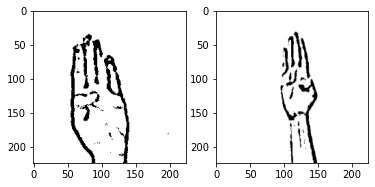

2 random images for code A


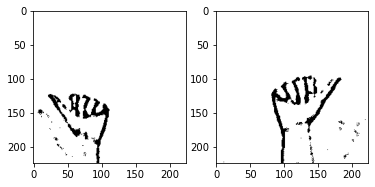

2 random images for code C


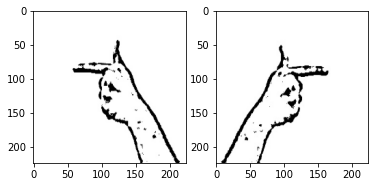

2 random images for code D


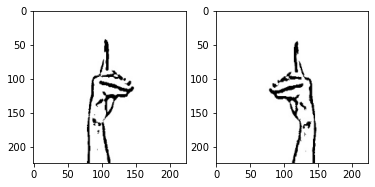

In [7]:
show_random_images(images, labels)


### Normalise...
We now convert the images and labels to NumPy arrays to make processing them easier. 

In [8]:
def normalise_images(images, labels):

    # Convert to numpy arrays
    images = np.array(images, dtype=np.float32)
    labels = np.array(labels)

    # Normalise the images
    images /= 255
    
    return images, labels

In [9]:
images, labels = normalise_images(images, labels)


### shuffle
we will shuffle the data so it is mixed up. before spliting it to train and test.

In [10]:
def shuffle_data(images, labels):

    # Set aside the testing data. We won't touch these until the very end.
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=728)
    
    return X_train, y_train

In [11]:
X_train, y_train = shuffle_data(images, labels)


## Loading pre-trained covnet model of :
### ResNet50, VGG16, VGG19
We'll now load up the keras models with the imagenet weights. We'll remove the top dense layers, since we won't need to classify things here, and we just want these encoded features from the images.

In [12]:
# Load the models with ImageNet weights
import tensorflow
from tensorflow.keras import applications
from tensorflow.keras.applications.resnet50 import ResNet50

# Load the models with ImageNet weights

vgg16_model = keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224,224,3))

vgg19_model = keras.applications.vgg19.VGG19(include_top=False, weights="imagenet", input_shape=(224,224,3))

resnet50_model = tensorflow.keras.applications.resnet50.ResNet50(include_top=False, weights="imagenet", input_shape=(224,224,3))


The covnet models will give us 3D vectors that represent the image. We need to flatten these for the clustering algorithms to start working with them.


In [13]:
def covnet_transform(covnet_model, raw_images):

    # Pass our training data through the network
    pred = covnet_model.predict(raw_images)

    # Flatten the array
    flat = pred.reshape(raw_images.shape[0], -1)
    
    return flat

In [14]:
vgg16_output = covnet_transform(vgg16_model, X_train)
print("VGG16 flattened output has {} features".format(vgg16_output.shape[1]))

vgg19_output = covnet_transform(vgg19_model, X_train)
print("VGG19 flattened output has {} features".format(vgg19_output.shape[1]))

resnet50_output = covnet_transform(resnet50_model, X_train)
print("ResNet50 flattened output has {} features".format(resnet50_output.shape[1]))

50/50 [==============================] - 243s 5s/step
VGG16 flattened output has 25088 features
50/50 [==============================] - 323s 6s/step
VGG19 flattened output has 25088 features
50/50 [==============================] - 105s 2s/step
ResNet50 flattened output has 100352 features


# PCA
While k-means clustering has coped with these numbers, Gaussian Mixture Modelling did not, the computer consistently run out of memory and struggled to produce results.

We therefore look to PCA for dimensionality reduction, so that our clustering algorithms can cope.

In [15]:
# Function that creates a PCA instance, fits it to the data and returns the instance
def create_fit_PCA(data, n_components=None):
    
    p = PCA(n_components=n_components, random_state=728)
    p.fit(data)
    
    return p

In [16]:
# Create PCA instances for each covnet output
vgg16_pca = create_fit_PCA(vgg16_output)
vgg19_pca = create_fit_PCA(vgg19_output)
resnet50_pca = create_fit_PCA(resnet50_output)


In [17]:
# Function to plot the cumulative explained variance of PCA components
# This will help us decide how many components we should reduce our features to
def pca_cumsum_plot(pca):
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.show()

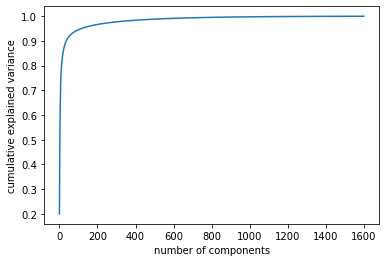

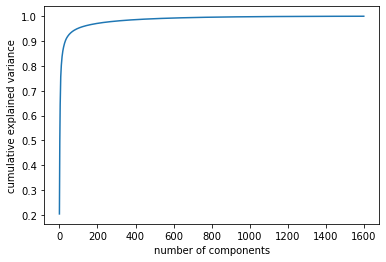

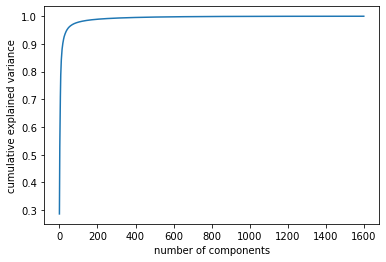

In [18]:
# Plot the cumulative explained variance for each covnet
pca_cumsum_plot(vgg16_pca)
pca_cumsum_plot(vgg19_pca)
pca_cumsum_plot(resnet50_pca)


Looking at the graph above, we can see that PCA can explain almost all the variance in as many dimensions as there are samples.

In [19]:
# PCA transformations of covnet outputs
vgg16_output_pca = vgg16_pca.transform(vgg16_output)
vgg19_output_pca = vgg19_pca.transform(vgg19_output)
resnet50_output_pca = resnet50_pca.transform(resnet50_output)


# Cluster
we wrote a couple of functions that would create and fit KMeans and Gaussian Mixture models. While it can make sense to combine them in one function that returns both, we've seperated them so we can execute them seperately and make some observations without overloading the PC

In [20]:
def create_train_kmeans(data, number_of_clusters=len(codes)):
    # n_jobs is set to -1 to use all available CPU cores. This makes a big difference on an 8-core CPU
    # especially when the data size gets much bigger. #perfMatters
    
    k = KMeans(n_clusters=number_of_clusters, n_jobs=-1, random_state=728)

    # Let's do some timings to see how long it takes to train.
    start = time.time()

    # Train it up
    k.fit(data)

    # Stop the timing 
    end = time.time()

    # And see how long that took
    print("Training took {} seconds".format(end-start))
    
    return k

In [21]:
def create_train_gmm(data, number_of_clusters=len(codes)):
    g = GaussianMixture(n_components=number_of_clusters, covariance_type="full", random_state=728)
    
    start=time.time()
    g.fit(data)
    end=time.time()
    
    print("Training took {} seconds".format(end-start))
    
    return g

In [22]:
# Let's pass the data into the algorithm and predict who lies in which cluster. 
# Since we're using the same data that we trained it on, this should give us the training results.

# Here we create and fit a KMeans model with the PCA outputs
print("KMeans (PCA): \n")

print("VGG16")
K_vgg16_pca = create_train_kmeans(vgg16_output_pca)

print("\nVGG19")
K_vgg19_pca = create_train_kmeans(vgg19_output_pca)

print("\nResNet50")
K_resnet50_pca = create_train_kmeans(resnet50_output_pca)

KMeans (PCA): 

VGG16


C:\Users\asahe\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Training took 0.9768946170806885 seconds

VGG19


C:\Users\asahe\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Training took 0.938819408416748 seconds

ResNet50


C:\Users\asahe\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Training took 1.005859136581421 seconds


In [23]:
# Same for Gaussian Model
print("GMM (PCA): \n")

print("VGG16")
G_vgg16_pca = create_train_gmm(vgg16_output_pca)

print("\nVGG19")
G_vgg19_pca = create_train_gmm(vgg19_output_pca)

print("\nResNet50")
G_resnet50_pca = create_train_gmm(resnet50_output_pca)

GMM (PCA): 

VGG16
Training took 4.691680669784546 seconds

VGG19
Training took 4.689667463302612 seconds

ResNet50
Training took 4.600181341171265 seconds


In [24]:
# Let's also create models for the covnet outputs without PCA for comparison
print("KMeans: \n")

print("VGG16:")
K_vgg16 = create_train_kmeans(vgg16_output)

print("\nVGG19:")
K_vgg19 = create_train_kmeans(vgg19_output)

print("\nResNet50:")
K_resnet50 = create_train_kmeans(resnet50_output)

KMeans: 

VGG16:


C:\Users\asahe\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Training took 10.79707407951355 seconds

VGG19:


C:\Users\asahe\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Training took 10.779236078262329 seconds

ResNet50:


C:\Users\asahe\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Training took 46.19611120223999 seconds


#### Attempts to run the Gaussian Mixtue Model on the outputs without PCA always give an out of memory error. Therefore we're unable to test these and conclude that they are impractical to use.

In [25]:
# Now we get the custer model predictions

# KMeans with PCA outputs
k_vgg16_pred_pca = K_vgg16_pca.predict(vgg16_output_pca)
k_vgg19_pred_pca = K_vgg19_pca.predict(vgg19_output_pca)
k_resnet50_pred_pca = K_resnet50_pca.predict(resnet50_output_pca)

# KMeans with CovNet outputs
k_vgg16_pred = K_vgg16.predict(vgg16_output)
k_vgg19_pred = K_vgg19.predict(vgg19_output)
k_resnet50_pred = K_resnet50.predict(resnet50_output)

# Gaussian Mixture with PCA outputs
g_vgg16_pred_pca = G_vgg16_pca.predict(vgg16_output_pca)
g_vgg19_pred_pca = G_vgg19_pca.predict(vgg19_output_pca)
g_resnet50_pred_pca = G_resnet50_pca.predict(resnet50_output_pca)

Remember that the clustering algorithm does not detect which images are A's and which are B's and so on, it only groups images that look alike together and assigns them a number arbitrarily.

We now need to count how many of each label are in each cluster, this way we can take a look and if sufficient eperation has happened we can quicly see which cluster is which label. So let's write a function that does that.

In [26]:
def cluster_label_count(clusters, labels):
    
    count = {}
    
    # Get unique clusters and labels
    unique_clusters = list(set(clusters))
    unique_labels = list(set(labels))
    
    # Create counter for each cluster/label combination and set it to 0
    for cluster in unique_clusters:
        count[cluster] = {}
        
        for label in unique_labels:
            count[cluster][label] = 0
    
    # Let's count
    for i in range(len(clusters)):
        count[clusters[i]][labels[i]] +=1
    
    cluster_df = pd.DataFrame(count)
    
    return cluster_df

In [27]:
# Cluster counting for VGG16 Means
vgg16_cluster_count = cluster_label_count(k_vgg16_pred, y_train)
vgg16_cluster_count_pca = cluster_label_count(k_vgg16_pred_pca, y_train)

# VGG19 KMeans
vgg19_cluster_count = cluster_label_count(k_vgg19_pred, y_train)
vgg19_cluster_count_pca = cluster_label_count(k_vgg19_pred_pca, y_train)

# ResNet50 KMeans
resnet_cluster_count = cluster_label_count(k_resnet50_pred, y_train)
resnet_cluster_count_pca = cluster_label_count(k_resnet50_pred_pca, y_train)

# GMM
g_vgg16_cluster_count_pca = cluster_label_count(g_vgg16_pred_pca, y_train)
g_vgg19_cluster_count_pca = cluster_label_count(g_vgg19_pred_pca, y_train)
g_resnet50_cluster_count_pca = cluster_label_count(g_resnet50_pred_pca, y_train)

In [28]:
print("KMeans VGG16: ")
vgg16_cluster_count

KMeans VGG16: 


,0,1,2,3
A,0,399,0,0
B,390,7,0,0
C,0,0,210,198
D,0,396,0,0


In [29]:
print("KMeans VGG16 (PCA): ")
vgg16_cluster_count_pca

KMeans VGG16 (PCA): 


,0,1,2,3
A,0,399,0,0
B,390,7,0,0
C,0,0,210,198
D,0,396,0,0


In [30]:
print("GMM VGG16: ")
g_vgg16_cluster_count_pca

GMM VGG16: 


,0,1,2,3
A,399,0,0,0
B,7,390,0,0
C,0,0,198,210
D,0,396,0,0


In [31]:
print("KMeans VGG19: ")
vgg19_cluster_count

KMeans VGG19: 


,0,1,2,3
A,0,399,0,0
B,390,7,0,0
C,0,0,210,198
D,0,396,0,0


In [32]:
print("KMeans VGG19 (PCA): ")
vgg19_cluster_count_pca

KMeans VGG19 (PCA): 


,0,1,2,3
A,0,399,0,0
B,390,7,0,0
C,0,0,210,198
D,0,396,0,0


In [33]:
print("GMM VGG19 (PCA): ")
g_vgg19_cluster_count_pca

GMM VGG19 (PCA): 


,0,1,2,3
A,399,0,0,0
B,7,390,0,0
C,0,0,198,210
D,0,0,396,0


In [34]:
print("KMeans Resnet50: ")
resnet_cluster_count

KMeans Resnet50: 


,0,1,2,3
A,0,221,0,178
B,0,194,0,203
C,198,0,210,0
D,0,193,0,203


In [35]:
print("Kmeans Resnet50 (PCA): ")
resnet_cluster_count_pca

Kmeans Resnet50 (PCA): 


,0,1,2,3
A,221,0,0,178
B,194,0,0,203
C,0,210,198,0
D,193,0,0,203


In [36]:
print("GMM Resnet50 (PCA): ")
g_resnet50_cluster_count_pca

GMM Resnet50 (PCA): 


,0,1,2,3
A,214,0,185,0
B,0,0,397,0
C,0,210,0,198
D,0,0,396,0


We can see again, that models which took ResNet50 representations could not produce meaningful clusters. We will therefore stop pursuing them.

The models that made it through are:

1. KMeans VGG16

2. KMeans VGG16 PCA

3. KMeans VGG19

4. KMeans VGG19 PCA

we will continue calculating some scores and see which performs best.

## Cluster - Label assignment
 In this part, we will manually look at the cluster count and give a best guess as to which cluster corresonds to which label. While normally each cluster will mostly consist of one label, it is not necessary the case if the clustering algorithm fails to seperate the images. It is therefore better to take stock here, and make sure that we are on the right path.

In [37]:
# Manually adjust these lists so that the index of each label reflects which cluster it lies in
vgg16_cluster_code =  ["B", "A", "C", "D"]
vgg16_cluster_code_pca =  ["B", "A", "C", "D"]

vgg19_cluster_code =  ["B", "A", "C", "D"]
vgg19_cluster_code_pca = ["B", "A", "C", "D"]


### Replace the predicted clusters with their labels


In [38]:
vgg16_pred_codes = [vgg16_cluster_code[x] for x in k_vgg16_pred]
vgg16_pred_codes_pca = [vgg16_cluster_code_pca[x] for x in k_vgg16_pred_pca]
vgg19_pred_codes = [vgg19_cluster_code[x] for x in k_vgg19_pred]
vgg19_pred_codes_pca = [vgg19_cluster_code_pca[x] for x in k_vgg19_pred_pca]

## metrics
Now that we have two arrays, one with the predicted labels and one with the true labels, we can go crazy with performance scores... or we can just compute the F1 score.


In [39]:
from sklearn.metrics import accuracy_score, f1_score

def print_scores(true, pred):
    acc = accuracy_score(true, pred)
    f1 = f1_score(true, pred, average="macro")
    return "\n\tF1 Score: {0:0.8f}   |   Accuracy: {0:0.8f}".format(f1,acc)

print("KMeans VGG16:", print_scores(y_train, vgg16_pred_codes))
print("KMeans VGG16 (PCA)", print_scores(y_train, vgg16_pred_codes_pca))

print("\nKMeans VGG19: ", print_scores(y_train, vgg19_pred_codes))
print("KMeans VGG19 (PCA): ", print_scores(y_train, vgg19_pred_codes_pca))

KMeans VGG16: 
	F1 Score: 0.58379085   |   Accuracy: 0.58379085
KMeans VGG16 (PCA) 
	F1 Score: 0.16611157   |   Accuracy: 0.16611157

KMeans VGG19:  
	F1 Score: 0.58379085   |   Accuracy: 0.58379085
KMeans VGG19 (PCA):  
	F1 Score: 0.58379085   |   Accuracy: 0.58379085


### of note:

The scores (and cluster counts) of PCA and non-PCA transformed outputs are exactly the same. Since we fixed all random states, with the only difference being the inputs, we can see that PCA-transformed data adequately represents the original data while givig us faster training times and lower memory usage.


The clusters for PCA and non-PCA transformed data are exactly in the same order.

### Testing Time
Ultimately, for best results, you would want to do this whole excercise every time you change your data in order to find out which model is the best for this particular data.

We can now then do the same thing for our testing data, and see if it gives the best accuracy again. We can keep testing this for more and more breed pairs to gain more confidence that our model works.

This is in the end an unsupevised learning excercise, and we would not be able to check which model is best for a particular set of data if we do not have labels for them. The closer your images are to the dataset images, the better chance you have of getting a high accuracy.

In [40]:
# Let's put it all together

def all_covnet_transform(data):
    vgg16 = covnet_transform(vgg16_model, data)
    vgg19 = covnet_transform(vgg19_model, data)
    resnet50 = covnet_transform(resnet50_model, data)
    
    return vgg16, vgg19, resnet50


def image_load_to_cluster_count(codes):
    # Load images
    images, labels = load_images(codes)
    print(len(images), len(labels))
    show_random_images(images, labels)
    
    # Normalise images
    images, labels = normalise_images(images, labels)
    
    # Split data
    data, labels = shuffle_data(images, labels)
    
    # Get covnet outputs
    vgg16_output, vgg19_output, resnet50_output = all_covnet_transform(data)
    
    # Get PCA transformations
    vgg16_output_pca = create_fit_PCA(vgg16_output).transform(vgg16_output)
    vgg19_output_pca = create_fit_PCA(vgg19_output).transform(vgg19_output)
    resnet50_output_pca = create_fit_PCA(resnet50_output).transform(resnet50_output)
    
    # Cluster
    clusters = len(codes)
    
    K_vgg16_pred = create_train_kmeans(vgg16_output, clusters).predict(vgg16_output)
    K_vgg19_pred = create_train_kmeans(vgg19_output, clusters).predict(vgg19_output)
    K_resnet50_pred = create_train_kmeans(resnet50_output, clusters).predict(resnet50_output)
    K_vgg16_pred_pca = create_train_kmeans(vgg16_output_pca, clusters).predict(vgg16_output_pca)
    K_vgg19_pred_pca = create_train_kmeans(vgg19_output_pca, clusters).predict(vgg19_output_pca)
    K_resnet50_pred_pca = create_train_kmeans(resnet50_output_pca, clusters).predict(resnet50_output_pca)
    G_vgg16_pred_pca = create_train_gmm(vgg16_output_pca, clusters).predict(vgg16_output_pca)
    G_vgg19_pred_pca = create_train_gmm(vgg19_output_pca, clusters).predict(vgg19_output_pca)
    G_resnet50_pred_pca = create_train_gmm(resnet50_output_pca, clusters).predict(resnet50_output_pca)
    
    # Count
    vgg16_cluster_count = cluster_label_count(K_vgg16_pred, labels)
    vgg16_cluster_count_pca = cluster_label_count(K_vgg16_pred_pca, labels)

    # VGG19 KMeans
    vgg19_cluster_count = cluster_label_count(K_vgg19_pred, labels)
    vgg19_cluster_count_pca = cluster_label_count(K_vgg19_pred_pca, labels)

    # ResNet50 KMeans
    resnet_cluster_count = cluster_label_count(K_resnet50_pred, labels)
    resnet_cluster_count_pca = cluster_label_count(K_resnet50_pred_pca, labels)

    # GMM
    g_vgg16_cluster_count_pca = cluster_label_count(G_vgg16_pred_pca, labels)
    g_vgg19_cluster_count_pca = cluster_label_count(G_vgg19_pred_pca, labels)
    g_resnet50_cluster_count_pca = cluster_label_count(G_resnet50_pred_pca, labels)
    
    print("KMeans VGG16: ")
    print(vgg16_cluster_count)
    print("\nKMeans VGG16 (PCA): ")
    print(vgg16_cluster_count_pca)
    print("\nGMM VGG16: ")
    print(g_vgg16_cluster_count_pca)
    print("\nKMeans VGG19: ")
    print(vgg19_cluster_count)
    print("\nKMeans VGG19 (PCA): ")
    print(vgg19_cluster_count_pca)
    print("GMM VGG19 (PCA): ")
    print(g_vgg19_cluster_count_pca)
    print("KMeans Resnet50: ")
    print(resnet_cluster_count)
    print("Kmeans Resnet50 (PCA): ")
    print(resnet_cluster_count_pca)
    print("GMM Resnet50 (PCA): ")
    print(g_resnet50_cluster_count_pca)
    
    return  K_vgg16_pred, K_vgg16_pred_pca, K_vgg19_pred, K_vgg19_pred_pca, G_vgg19_pred_pca, images, labels

1500 1500
2 random images for code B


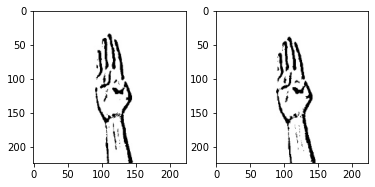

2 random images for code A


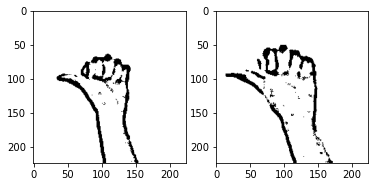

2 random images for code C


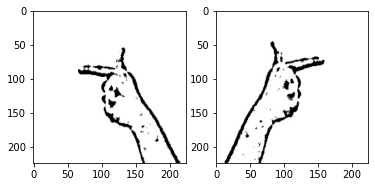

38/38 [==============================] - 101s 3s/step


C:\Users\asahe\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Training took 10.42375922203064 seconds


C:\Users\asahe\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Training took 9.61256718635559 seconds


C:\Users\asahe\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Training took 36.095924377441406 seconds


C:\Users\asahe\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Training took 0.43903684616088867 seconds


C:\Users\asahe\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Training took 0.42475175857543945 seconds


C:\Users\asahe\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Training took 0.4829235076904297 seconds
Training took 1.9989893436431885 seconds
Training took 1.9348554611206055 seconds
Training took 1.980574369430542 seconds
KMeans VGG16: 
     0    1    2
B    6  390    0
A  398    0    0
C  197    0  209

KMeans VGG16 (PCA): 
     0    1    2
B    6  390    0
A  398    0    0
C  197    0  209

GMM VGG16: 
     0    1    2
B    6  197  193
A  398    0    0
C    0  209  197

KMeans VGG19: 
     0    1    2
B    0  390    6
A    0    0  398
C  197    0  209

KMeans VGG19 (PCA): 
     0    1    2
B  390    6    0
A    0  398    0
C    0  209  197
GMM VGG19 (PCA): 
     0    1    2
B  199  197    0
A  398    0    0
C    0  209  197
KMeans Resnet50: 
     0    1    2
B    0  396    0
A    0  265  133
C  197    0  209
Kmeans Resnet50 (PCA): 
     0    1    2
B    0  396    0
A    0  265  133
C  197    0  209
GMM Resnet50 (PCA): 
     0    1    2
B    2  394    0
A  204  194    0
C    0  209  197


In [41]:
codes = ["A", "B", "C"]
outputs = image_load_to_cluster_count(codes)

In [42]:
# Manually adjust these lists so that the index of each label reflects which cluter it lies in
vgg16_cluster_code = ["A", "B", "C"]
vgg16_cluster_code_pca = ["A", "B", "C"]

vgg19_cluster_code = ["B", "A", "C"]
vgg19_cluster_code_pca = ["B", "A", "C"]
g_vgg19_cluster_code_pca = ["A", "B", "C"]


vgg16_pred_codes = [vgg16_cluster_code[x] for x in outputs[0]]
vgg16_pred_codes_pca = [vgg16_cluster_code_pca[x] for x in outputs[1]]
vgg19_pred_codes = [vgg19_cluster_code[x] for x in outputs[2]]
vgg19_pred_codes_pca = [vgg19_cluster_code_pca[x] for x in outputs[3]]
g_vgg19_pred_codes_pca = [g_vgg19_cluster_code_pca[x] for x in outputs[4]]

print("KMeans VGG16:", print_scores(outputs[-1], vgg16_pred_codes))
print("KMeans VGG16 (PCA)", print_scores(outputs[-1], vgg16_pred_codes_pca))

print("\nKMeans VGG19: ", print_scores(outputs[-1], vgg19_pred_codes))
print("KMeans VGG19 (PCA): ", print_scores(outputs[-1], vgg19_pred_codes_pca))
print("GMM VGG19 (PCA)", print_scores(outputs[-1], g_vgg19_pred_codes_pca))

KMeans VGG16: 
	F1 Score: 0.82294600   |   Accuracy: 0.82294600
KMeans VGG16 (PCA) 
	F1 Score: 0.82294600   |   Accuracy: 0.82294600

KMeans VGG19:  
	F1 Score: 0.13673536   |   Accuracy: 0.13673536
KMeans VGG19 (PCA):  
	F1 Score: 0.81103512   |   Accuracy: 0.81103512
GMM VGG19 (PCA) 
	F1 Score: 0.64822383   |   Accuracy: 0.64822383


1000 1000
2 random images for code B


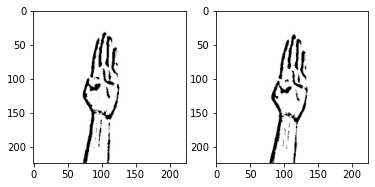

2 random images for code A


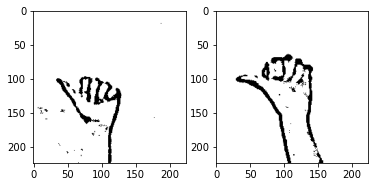

25/25 [==============================] - 58s 2s/step


C:\Users\asahe\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Training took 3.9872634410858154 seconds


C:\Users\asahe\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Training took 4.0089569091796875 seconds


C:\Users\asahe\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Training took 15.109345436096191 seconds


C:\Users\asahe\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
C:\Users\asahe\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Training took 0.15358853340148926 seconds
Training took 0.17039918899536133 seconds


C:\Users\asahe\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Training took 0.18416357040405273 seconds
Training took 0.5579447746276855 seconds
Training took 0.49765992164611816 seconds
Training took 0.4779949188232422 seconds
KMeans VGG16: 
     0    1
B  389    6
A    0  405

KMeans VGG16 (PCA): 
     0    1
B    6  389
A  405    0

GMM VGG16: 
     0    1
B  389    6
A    0  405

KMeans VGG19: 
     0    1
B  389    6
A    0  405

KMeans VGG19 (PCA): 
     0    1
B  389    6
A    0  405
GMM VGG19 (PCA): 
     0    1
B  389    6
A    0  405
KMeans Resnet50: 
     0    1
B    0  395
A  199  206
Kmeans Resnet50 (PCA): 
     0    1
B    0  395
A  199  206
GMM Resnet50 (PCA): 
     0    1
B  395    0
A  192  213


In [43]:
codes = ["A", "B"]
outputs = image_load_to_cluster_count(codes)

By now we can see that ResNet is performing terribly in all our tests. We can also see that PCA and non-PCA are the same, so we can just use the same cluster/code combinations for them, and that GMM has consistently performed same as or much worse than KMeans.

The two we will consider now are Kmeans VGG16 and VGG19

In [44]:
# Manually adjust these lists so that the index of each label reflects which cluter it lies in
vgg16_cluster_code = ["B", "A"]
vgg19_cluster_code = ["B","A"]

In [45]:
# Let's define a function for scores

def scoring(vgg16_cluster_code, vgg19_cluster_code, outputs):
    vgg16_pred_codes = [vgg16_cluster_code[x] for x in outputs[0]]
    vgg16_pred_codes_pca = [vgg16_cluster_code[x] for x in outputs[1]]
    vgg19_pred_codes = [vgg19_cluster_code[x] for x in outputs[2]]
    vgg19_pred_codes_pca = [vgg19_cluster_code[x] for x in outputs[3]]

    print("KMeans VGG16:", print_scores(outputs[-1], vgg16_pred_codes))
    print("KMeans VGG16 (PCA)", print_scores(outputs[-1], vgg16_pred_codes_pca))

    print("\nKMeans VGG19: ", print_scores(outputs[-1], vgg19_pred_codes))
    print("KMeans VGG19 (PCA): ", print_scores(outputs[-1], vgg19_pred_codes_pca))

In [46]:
scoring(vgg16_cluster_code, vgg19_cluster_code, outputs)

KMeans VGG16: 
	F1 Score: 0.99249700   |   Accuracy: 0.99249700
KMeans VGG16 (PCA) 
	F1 Score: 0.00744417   |   Accuracy: 0.00744417

KMeans VGG19:  
	F1 Score: 0.99249700   |   Accuracy: 0.99249700
KMeans VGG19 (PCA):  
	F1 Score: 0.99249700   |   Accuracy: 0.99249700


1000 1000
2 random images for code C


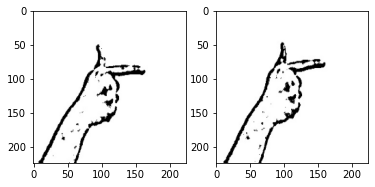

2 random images for code D


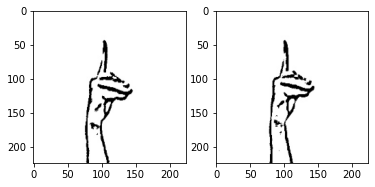

25/25 [==============================] - 58s 2s/step


C:\Users\asahe\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Training took 3.862783432006836 seconds


C:\Users\asahe\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Training took 3.8114326000213623 seconds


C:\Users\asahe\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Training took 22.049950122833252 seconds


C:\Users\asahe\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
C:\Users\asahe\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Training took 0.1672682762145996 seconds
Training took 0.1613006591796875 seconds


C:\Users\asahe\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Training took 0.15623879432678223 seconds
Training took 0.5674386024475098 seconds
Training took 0.5305721759796143 seconds
Training took 0.5215420722961426 seconds
KMeans VGG16: 
     0    1
C  208  197
D    0  395

KMeans VGG16 (PCA): 
     0    1
C  208  197
D    0  395

GMM VGG16: 
     0    1
C  208  197
D  395    0

KMeans VGG19: 
     0    1
C  197  208
D  395    0

KMeans VGG19 (PCA): 
     0    1
C  197  208
D  395    0
GMM VGG19 (PCA): 
     0    1
C  197  208
D  395    0
KMeans Resnet50: 
     0    1
C  208  197
D    0  395
Kmeans Resnet50 (PCA): 
     0    1
C  208  197
D    0  395
GMM Resnet50 (PCA): 
     0    1
C  208  197
D  195  200


In [47]:
codes = ["C", "D"]
outputs = image_load_to_cluster_count(codes)

In [48]:
vgg16_cluster_code = ["C", "D"]
vgg19_cluster_code = ["D","C"]
scoring(vgg16_cluster_code, vgg19_cluster_code, outputs)

KMeans VGG16: 
	F1 Score: 0.73951748   |   Accuracy: 0.73951748
KMeans VGG16 (PCA) 
	F1 Score: 0.73951748   |   Accuracy: 0.73951748

KMeans VGG19:  
	F1 Score: 0.73951748   |   Accuracy: 0.73951748
KMeans VGG19 (PCA):  
	F1 Score: 0.73951748   |   Accuracy: 0.73951748
